<a href="https://colab.research.google.com/github/Luisamfer/Ativ_Est_Desc/blob/main/Estat_desc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#INFORMAÇÕES DO CADASTRO NACIONAL DA AGRICULTURA FAMILIAR(CAF)#

#*População Acessível*: Agricultores Familiares que realizaram o Cadastro Nacional da Agricultura Familiar#
#*Objetivo do estudo*: Verificar as informações cadastradas no CAF, identificar características dos agricultores familiares cadastrados, permitindo verificação posterior quanto a relação entre o perfil dos agricultores e respectiva produção #

# As informações do CAF a serem trabalhadas estão divididas em 3 bancos de dados: MEMBROS, que traz alguns dados cadastrais dos agricultores familiares; AREA, que traz algumas informações das áreas exploradas declaradas; RENDA, que traz as informações de rendas recebidas nos últimos 12 meses pela Unidade Familiar de Produção (UFPA).

# As variáveis trabalhadas, em sua maioria, são categóricas. A variável contínua é apenas a RENDA.

# A chave única que vincula os bancos de dados é o número do CAF, que corresnponde ao número da UFPA.




In [2]:
# Importando as bibliotecas necessárias para análises
import pandas as pd
from scipy.stats import chi2_contingency
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import statistics as st
from datetime import datetime

In [3]:
# Importando o arquivo pelo Google Drive
from google.colab import drive

# Carregando arquivos
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#Carregando o arquivo de MEMBROS da UFPA
df_membros = pd.read_csv("/content/drive/My Drive/Colab Notebooks/MBA_Est_Desc_dados/MEMBROS.csv", sep=';', encoding='utf-8', dtype={
    "CAF":"string",
    "CODIGO_PESSOA":"string",
    "SEXO":"category",
    "ESCOLARIDADE":"category",
    "MAO_DE_OBRA_FAMILIAR":"category"
    })

### Tendo em vista que já conheço o banco de dados e suas variáveis, identifiquei previamente os formatos necessários na importação. ###

# Verificando se os dados foram importados corretamente (quantidade e formatos)
df_membros.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4535543 entries, 0 to 4535542
Data columns (total 6 columns):
 #   Column                Dtype   
---  ------                -----   
 0   CAF                   string  
 1   CODIGO_PESSOA         string  
 2   SEXO                  category
 3   DATA_NASCIMENTO       object  
 4   ESCOLARIDADE          category
 5   MAO_DE_OBRA_FAMILIAR  category
dtypes: category(3), object(1), string(2)
memory usage: 116.8+ MB


In [5]:
# Convertendo a variável DATA_NASCIMENTO para formato datetime
df_membros["DATA_NASCIMENTO"] = pd.to_datetime(df_membros["DATA_NASCIMENTO"], dayfirst=True, errors='coerce')

# Calculando a idade de cada MEMBRO da UFPA
hoje = datetime.today()
df_membros["IDADE"] = df_membros["DATA_NASCIMENTO"].apply(lambda x: int(hoje.year - x.year - ((hoje.month, hoje.day) < (x.month, x.day))) if pd.notnull(x) else None)

#Visualizando a criação da nova variável
df_membros.head()

#Obtendo resumo estatístico da base importada
df_membros.describe()

,DATA_NASCIMENTO,IDADE
count,4535543,4.535543e+06
mean,1982-11-09 22:08:21.858498432,4.182512e+01
min,1909-05-19 00:00:00,0.000000e+00
25%,1968-09-11 00:00:00,2.800000e+01
50%,1981-06-23 00:00:00,4.300000e+01
75%,1996-09-19 00:00:00,5.600000e+01
max,2025-02-13 00:00:00,1.150000e+02
std,NaN,1.837484e+01


In [6]:
#Criando a variável FAIXA ETÁRIA para melhor classificação das idades.
def definir_faixa_etaria(IDADE):
  if IDADE <= 15:
    return "Menor de 15 anos"
  elif IDADE <= 29:
    return "16 a 29 anos"
  elif IDADE <= 39:
    return "30 a 39 anos"
  elif IDADE <= 49:
    return "40 a 49 anos"
  elif IDADE <= 59:
    return "50 a 59 anos"
  elif IDADE <= 69:
    return "60 a 69 anos"
  elif IDADE <= 79:
    return "70 a 79 anos"
  elif IDADE <= 89:
    return "80 a 89 anos"
  elif IDADE > 89:
    return "Mais de 90 anos"

  return pd.NA

df_membros['FAIXA_ETARIA'] = df_membros["IDADE"].apply(definir_faixa_etaria)
df_membros.head()

,CAF,CODIGO_PESSOA,SEXO,DATA_NASCIMENTO,ESCOLARIDADE,MAO_DE_OBRA_FAMILIAR,IDADE,FAIXA_ETARIA
0,AC012023.01.000103697CAF,228471,FEMININO,1950-02-17,ANALFABETO,SIM,75,70 a 79 anos
1,AC012023.01.000103709CAF,228657,MASCULINO,1994-03-01,MEDIO_COMPLETO,SIM,31,30 a 39 anos
2,AC012023.01.000103709CAF,228738,FEMININO,1998-03-01,MEDIO_COMPLETO,NÃO,27,16 a 29 anos
3,AC012023.01.000103723CAF,228694,MASCULINO,1969-06-21,ANALFABETO,SIM,55,50 a 59 anos
4,AC012023.01.000103723CAF,228735,FEMININO,1982-02-28,ANALFABETO,SIM,43,40 a 49 anos


In [8]:
#ORDEM PARA APRESENTAÇÃO DA FAIXA ETÁRIA
ordem_faixa = ["Menor de 15 anos", "16 a 29 anos", "30 a 39 anos", "40 a 49 anos", "50 a 59 anos", "60 a 69 anos", "70 a 79 anos", "80 a 89 anos", "Mais de 90 anos"]
df_membros["FAIXA_ETARIA"] = pd.Categorical(df_membros["FAIXA_ETARIA"], categories=ordem_faixa, ordered=True)

#TABELA DE FREQUENCIA DAS VARIÁVEIS
for col in df_membros.select_dtypes(include=['object', 'category']):
    print(f'Frequência Absoluta {col}:')
    freq = df_membros[col].value_counts().sort_index()
    freq.loc['Total'] = freq.sum()
    print(freq)
    print()

#TABELA DE FREQUENCIA RELATIVA DAS VARIÁVEIS
for col in df_membros.select_dtypes(include=['object', 'category']):
    print(f'Frequência Relativa {col}:')
    freq_rel = df_membros[col].value_counts(normalize=True).sort_index()
    freq_rel.loc['Total'] = freq_rel.sum()
    print(freq_rel)
    print()


Frequência Absoluta SEXO:
SEXO
FEMININO     2263996
MASCULINO    2271547
Total        4535543
Name: count, dtype: int64

Frequência Absoluta ESCOLARIDADE:
ESCOLARIDADE
ANALFABETO                 434934
FUNDAMENTAL_COMPLETO       540395
FUNDAMENTAL_INCOMPLETO    1982629
MEDIO_COMPLETO             977861
MEDIO_INCOMPLETO           398167
SUPERIOR_COMPLETO          142938
SUPERIOR_INCOMPLETO         58616
Total                     4535540
Name: count, dtype: int64

Frequência Absoluta MAO_DE_OBRA_FAMILIAR:
MAO_DE_OBRA_FAMILIAR
NÃO       677242
SIM      3858301
Total    4535543
Name: count, dtype: int64

Frequência Absoluta FAIXA_ETARIA:
FAIXA_ETARIA
Menor de 15 anos     410862
16 a 29 anos         825272
30 a 39 anos         723906
40 a 49 anos         837827
50 a 59 anos         923512
60 a 69 anos         578150
70 a 79 anos         195476
80 a 89 anos          37486
Mais de 90 anos        3052
Total               4535543
Name: count, dtype: int64

Frequência Relativa SEXO:
SEXO
FEMININ

In [8]:
#TABELA DE FREQUENCIA CRUZADA DA VARIÁVEL FAIXA ETÁRIA E INFORMAÇÃO SE O MEMBRO É MÃO DE OBRA FAMILIAR
tabela_cruzada = pd.crosstab(df_membros["FAIXA_ETARIA"], df_membros["MAO_DE_OBRA_FAMILIAR"], margins=True, margins_name="Total").sort_index()
print(tabela_cruzada)

MAO_DE_OBRA_FAMILIAR     NÃO      SIM    Total
FAIXA_ETARIA                                  
16 a 29 anos          156140   669132   825272
30 a 39 anos           24180   699726   723906
40 a 49 anos           26328   811499   837827
50 a 59 anos           30718   892794   923512
60 a 69 anos           17447   560703   578150
70 a 79 anos            7069   188407   195476
80 a 89 anos            3619    33867    37486
Mais de 90 anos         1005     2047     3052
Menor de 15 anos      410736      126   410862
Total                 677242  3858301  4535543


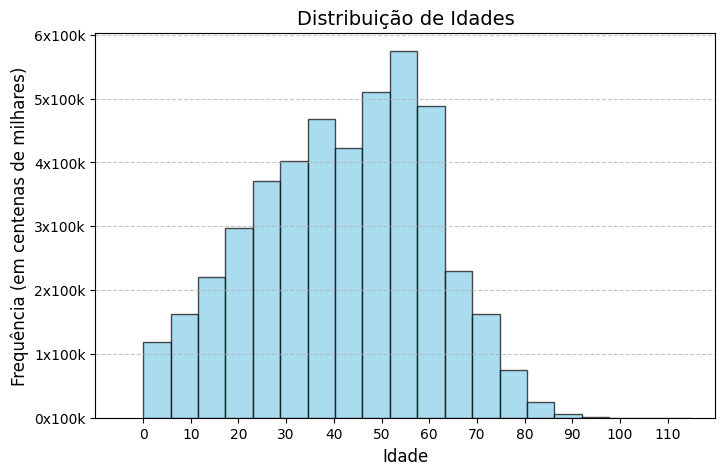

In [20]:
#CRIANDO HISTOGRAMA PARA AS IDADES DOS AGRICULTORES FAMILIARES
idades = df_membros["IDADE"]
plt.figure(figsize=(8, 5))  # Ajusta o tamanho do gráfico
plt.hist(idades, bins=20, color="skyblue", edgecolor="black", alpha=0.7)  # Personalização

# Ajustando o eixo Y para escala de 100.000
plt.gca().get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x/100000)}x100k'))

# Ajustando o eixo X
plt.xlim(-10, 120)
plt.xticks([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110])

# Adicionando rótulos e título
plt.xlabel("Idade", fontsize=12)
plt.ylabel("Frequência (em centenas de milhares)", fontsize=12)
plt.title("Distribuição de Idades", fontsize=14)

# Adicionando uma grade
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Exibindo o gráfico
plt.show()

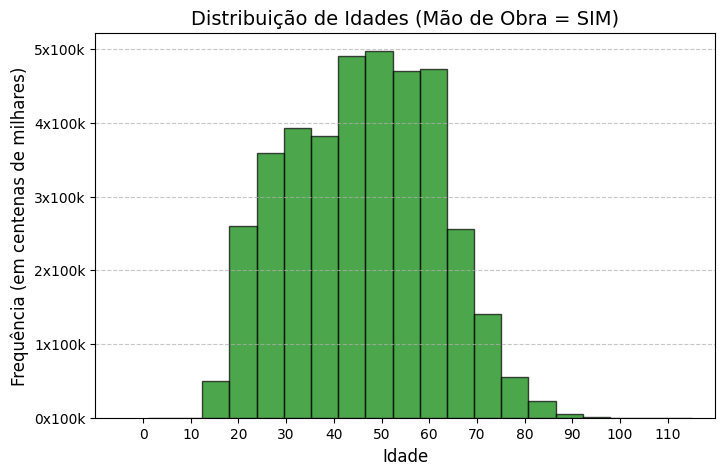

In [21]:
#CRIANDO HISTOGRAMA PARA AS IDADES DOS AGRICULTORES FAMILIARES
idades_sim = df_membros[df_membros['MAO_DE_OBRA_FAMILIAR'] == 'SIM']["IDADE"]
plt.figure(figsize=(8, 5))  # Ajusta o tamanho do gráfico
plt.hist(idades_sim, bins=20, color="green", edgecolor="black", alpha=0.7)  # Personalização

# Ajustando o eixo Y para escala de 100.000
plt.gca().get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x/100000)}x100k'))

# Ajustando o eixo X
plt.xlim(-10, 120)
plt.xticks([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110])

# Adicionando rótulos e título
plt.xlabel("Idade", fontsize=12)
plt.ylabel("Frequência (em centenas de milhares)", fontsize=12)
plt.title("Distribuição de Idades (Mão de Obra = SIM)", fontsize=14)

# Adicionando uma grade
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Exibindo o gráfico
plt.show()

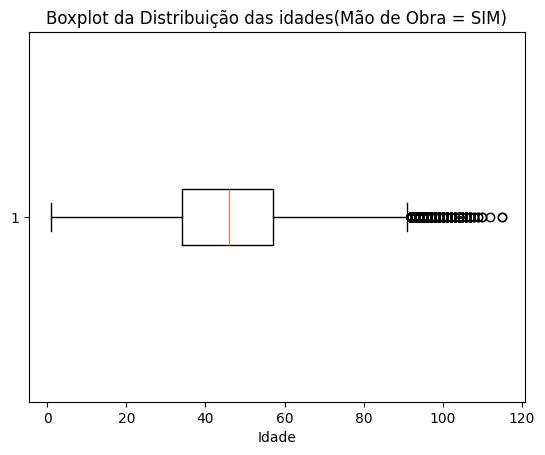

In [22]:
#CRIANDO UM BOXPLOT PARA VERIFICAR A DISTRIBUIÇÃO DOS DADOS E OUTLIERS
plt.boxplot(idades_sim, vert=False)
plt.title("Boxplot da Distribuição das idades(Mão de Obra = SIM)")
plt.xlabel("Idade")
plt.show()

In [23]:
# APRESENTANTO OS VALORES DOS QUARTIS (MÃO DE OBRA = SIM)
Q1_idade = df_membros[df_membros['MAO_DE_OBRA_FAMILIAR'] == 'SIM']["IDADE"].quantile(0.25)
Q2_idade = df_membros[df_membros['MAO_DE_OBRA_FAMILIAR'] == 'SIM']["IDADE"].quantile(0.50)
Q3_idade = df_membros[df_membros['MAO_DE_OBRA_FAMILIAR'] == 'SIM']["IDADE"].quantile(0.75)
print(f'Q1 (25%) = {Q1_idade}')
print(f'Q2 (50%) = {Q2_idade}')
print(f'Q3 (75%) = {Q3_idade}')

Q1 (25%) = 34.0
Q2 (50%) = 46.0
Q3 (75%) = 57.0


In [17]:
# APRESENTANTO OS VALORES DOS QUARTIS
Q1_idade = df_membros["IDADE"].quantile(0.25)
Q2_idade = df_membros["IDADE"].quantile(0.50)
Q3_idade = df_membros["IDADE"].quantile(0.75)
print(f'Q1 (25%) = {Q1_idade}')
print(f'Q2 (50%) = {Q2_idade}')
print(f'Q3 (75%) = {Q3_idade}')

Q1 (25%) = 28.0
Q2 (50%) = 43.0
Q3 (75%) = 56.0


In [38]:
#TABELA DE FREQUENCIA CRUZADA DA VARIÁVEL ESCOLARIDADE E INFORMAÇÃO SE O MEMBRO É MÃO DE OBRA FAMILIAR
tabela_cruzada_2 = pd.crosstab(df_membros["ESCOLARIDADE"], df_membros["MAO_DE_OBRA_FAMILIAR"], normalize='index').sort_index()
print(tabela_cruzada_2)

MAO_DE_OBRA_FAMILIAR         NÃO       SIM
ESCOLARIDADE                              
ANALFABETO              0.349283  0.650717
FUNDAMENTAL_COMPLETO    0.075008  0.924992
FUNDAMENTAL_INCOMPLETO  0.165836  0.834164
MEDIO_COMPLETO          0.051959  0.948041
MEDIO_INCOMPLETO        0.194293  0.805707
SUPERIOR_COMPLETO       0.134128  0.865872
SUPERIOR_INCOMPLETO     0.147673  0.852327


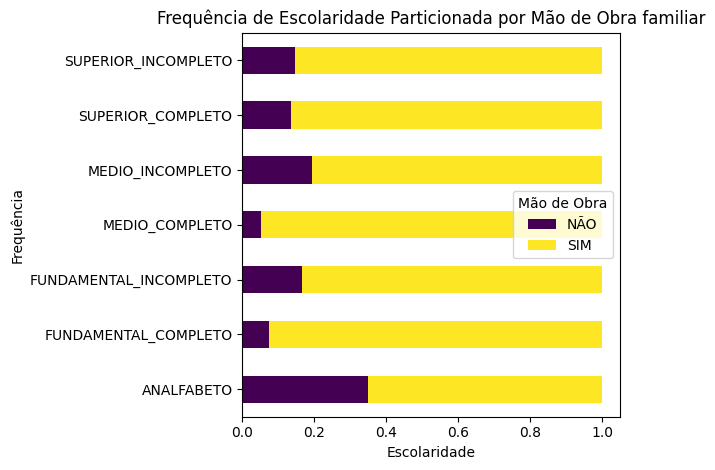

In [39]:
# GRÁFICO DE FREQUENCIA PARTICIONADO

# Gráfico de barras empilhadas
tabela_cruzada_2.plot(kind='barh', stacked=True, colormap='viridis')

plt.xlabel('Escolaridade')
plt.ylabel('Frequência')
plt.title('Frequência de Escolaridade Particionada por Mão de Obra familiar')
plt.legend(title='Mão de Obra')
plt.tight_layout()
plt.show()

<ipython-input-12-0620a5dbb9e2>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='FAIXA_ETARIA', data=df_membros, palette='Purples', edgecolor='black')


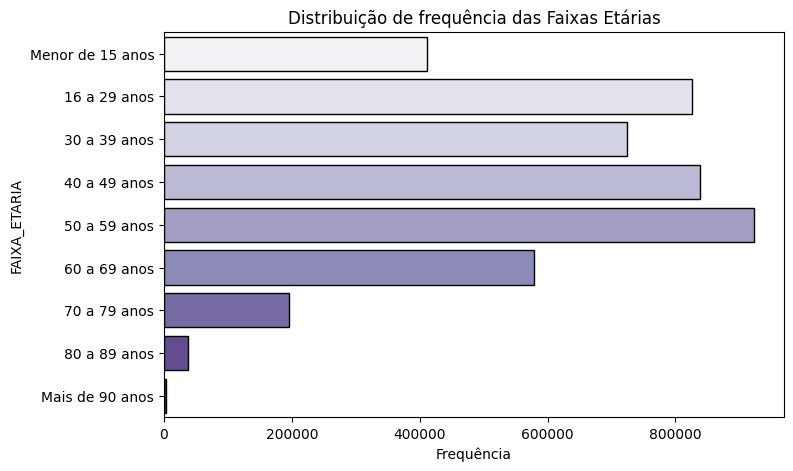

In [12]:
#GRÁFICO DE BARRAS PARA FAIXA ETÁRIA
plt.figure(figsize=(8, 5))

# Criando o gráfico de barras
sns.countplot(y='FAIXA_ETARIA', data=df_membros, palette='Purples', edgecolor='black')

# Personalizando
plt.ylabel('FAIXA_ETARIA')
plt.xlabel('Frequência')
plt.title('Distribuição de frequência das Faixas Etárias')

plt.show()

In [ ]:
# Carregando arquivo de ÁREA
df_area = pd.read_csv("/content/drive/My Drive/Colab Notebooks/MBA_Est_Desc_dados/AREA.csv", sep=';', encoding='utf-8', dtype={
    "CAF":"string",
    "UF":"string",
    "MUNICIPIO":"string",
    "IMOVEL_PRINCIPAL":"category",
    "USO_TERRA":"category"
    })


In [ ]:
print(df_area)

In [14]:
# Verificando se os dados foram importados corretamente (quantidade e formatos)
df_area.info()

#Verificando as informções importadas
df_area.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2587032 entries, 0 to 2587031
Data columns (total 5 columns):
 #   Column            Dtype   
---  ------            -----   
 0   CAF               string  
 1   UF                string  
 2   MUNICIPIO         string  
 3   IMOVEL_PRINCIPAL  category
 4   USO_TERRA         category
dtypes: category(2), string(3)
memory usage: 64.1 MB


,CAF,UF,MUNICIPIO,IMOVEL_PRINCIPAL,USO_TERRA
0,AC012023.01.000103697CAF,AC,PLÁCIDO DE CASTRO,SIM,PROPRIETÁRIO
1,AC012023.01.000103709CAF,AC,FEIJÓ,SIM,POSSEIRO/POSSUIDOR
2,AC012023.01.000103723CAF,AC,SENA MADUREIRA,SIM,ASSENTADO DA REFORMA AGRÁRIA
3,AC012023.01.000103941CAF,AC,TARAUACÁ,SIM,POSSEIRO/POSSUIDOR
4,AC012023.01.000103982CAF,AC,CRUZEIRO DO SUL,SIM,POSSEIRO/POSSUIDOR


In [15]:
# Transformando a variável UF → Região
uf_para_regiao = {
    'SP': 'Sudeste', 'RJ': 'Sudeste', 'MG': 'Sudeste', 'ES': 'Sudeste',
    'PR': 'Sul', 'SC': 'Sul', 'RS': 'Sul',
    'BA': 'Nordeste', 'PE': 'Nordeste', 'CE': 'Nordeste', 'MA': 'Nordeste',
    'PB': 'Nordeste', 'RN': 'Nordeste', 'PI': 'Nordeste', 'AL': 'Nordeste', 'SE': 'Nordeste',
    'DF': 'Centro-Oeste', 'GO': 'Centro-Oeste', 'MT': 'Centro-Oeste', 'MS': 'Centro-Oeste',
    'AM': 'Norte', 'PA': 'Norte', 'RO': 'Norte', 'RR': 'Norte', 'AC': 'Norte',
    'AP': 'Norte', 'TO': 'Norte'
}

# Criando a nova coluna "REGIÃO"
df_area['REGIAO'] = df_area['UF'].map(uf_para_regiao)

df_area.head()

,CAF,UF,MUNICIPIO,IMOVEL_PRINCIPAL,USO_TERRA,REGIAO
0,AC012023.01.000103697CAF,AC,PLÁCIDO DE CASTRO,SIM,PROPRIETÁRIO,Norte
1,AC012023.01.000103709CAF,AC,FEIJÓ,SIM,POSSEIRO/POSSUIDOR,Norte
2,AC012023.01.000103723CAF,AC,SENA MADUREIRA,SIM,ASSENTADO DA REFORMA AGRÁRIA,Norte
3,AC012023.01.000103941CAF,AC,TARAUACÁ,SIM,POSSEIRO/POSSUIDOR,Norte
4,AC012023.01.000103982CAF,AC,CRUZEIRO DO SUL,SIM,POSSEIRO/POSSUIDOR,Norte


In [45]:
#TABELA DE FREQUENCIA DE UFPAs POR UF
freq_uf = df_area.groupby('UF')['CAF'].nunique().reset_index()
freq_uf.columns = ["UF", "Frequência"]
freq_uf


,UF,Frequência
0,AC,13888
1,AL,61224
2,AM,28031
3,AP,9748
4,BA,438454
5,CE,255989
6,DF,2416
7,ES,38653
8,EX,1
9,GO,22002


In [46]:
#TABELA DE FREQUENCIA DE UFPAs POR REGIÃO
freq_uf = df_area.groupby('REGIAO')['CAF'].nunique().reset_index()
freq_uf.columns = ["Região", "Frequência"]
freq_uf

,Região,Frequência
0,Centro-Oeste,59267
1,Nordeste,1606025
2,Norte,194487
3,Sudeste,251189
4,Sul,254527


In [16]:
# FAZENDO FILTRO NA VARIÁVEL DE INTERESSE
df_area_principal = df_area[df_area["IMOVEL_PRINCIPAL"] == "SIM"]

# VERIFICANDO QUANTAS UFPAs RESTARAM APÓS O FILTRO
df_area_principal.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2365363 entries, 0 to 2587031
Data columns (total 6 columns):
 #   Column            Dtype   
---  ------            -----   
 0   CAF               string  
 1   UF                string  
 2   MUNICIPIO         string  
 3   IMOVEL_PRINCIPAL  category
 4   USO_TERRA         category
 5   REGIAO            object  
dtypes: category(2), object(1), string(3)
memory usage: 94.7+ MB


In [18]:
# JUNTANDO OS 2 DATAFRAMES PARA LOCALIZAR OS MEMBROS DAS UFPAs
# PEGANDO APENAS AS VARIÁVEIS DE INTERESSE NO DATAFRAME DE ÁREA

df_membros_area = pd.merge(df_membros, df_area_principal[["CAF", "UF", "MUNICIPIO", "REGIAO"]], on="CAF", how="inner")
df_membros_area.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4535535 entries, 0 to 4535534
Data columns (total 11 columns):
 #   Column                Dtype         
---  ------                -----         
 0   CAF                   string        
 1   CODIGO_PESSOA         string        
 2   SEXO                  category      
 3   DATA_NASCIMENTO       datetime64[ns]
 4   ESCOLARIDADE          category      
 5   MAO_DE_OBRA_FAMILIAR  category      
 6   IDADE                 int64         
 7   FAIXA_ETARIA          category      
 8   UF                    string        
 9   MUNICIPIO             string        
 10  REGIAO                object        
dtypes: category(4), datetime64[ns](1), int64(1), object(1), string(4)
memory usage: 259.5+ MB


In [36]:
#TABELA DE FREQUENCIA CRUZADA DA VARIÁVEL ESCOLARIDADE E INFORMAÇÃO DE REGIÃO
tabela_cruzada_2 = pd.crosstab(df_membros_area["ESCOLARIDADE"], df_membros_area["REGIAO"], normalize='columns', margins=True, margins_name="Total").sort_index()
print(tabela_cruzada_2)


REGIAO                  Centro-Oeste  Nordeste     Norte   Sudeste       Sul  \
ESCOLARIDADE                                                                   
ANALFABETO                  0.051620  0.113974  0.088774  0.067977  0.031088   
FUNDAMENTAL_COMPLETO        0.154824  0.109370  0.121607  0.129815  0.157291   
FUNDAMENTAL_INCOMPLETO      0.359610  0.451812  0.431832  0.407103  0.400968   
MEDIO_COMPLETO              0.237834  0.206013  0.212708  0.240322  0.245068   
MEDIO_INCOMPLETO            0.091067  0.090852  0.091303  0.081701  0.072190   
SUPERIOR_COMPLETO           0.081378  0.018434  0.038532  0.056869  0.067667   
SUPERIOR_INCOMPLETO         0.023666  0.009546  0.015244  0.016214  0.025727   

REGIAO                     Total  
ESCOLARIDADE                      
ANALFABETO              0.095895  
FUNDAMENTAL_COMPLETO    0.119147  
FUNDAMENTAL_INCOMPLETO  0.437132  
MEDIO_COMPLETO          0.215600  
MEDIO_INCOMPLETO        0.087788  
SUPERIOR_COMPLETO       0.031515  

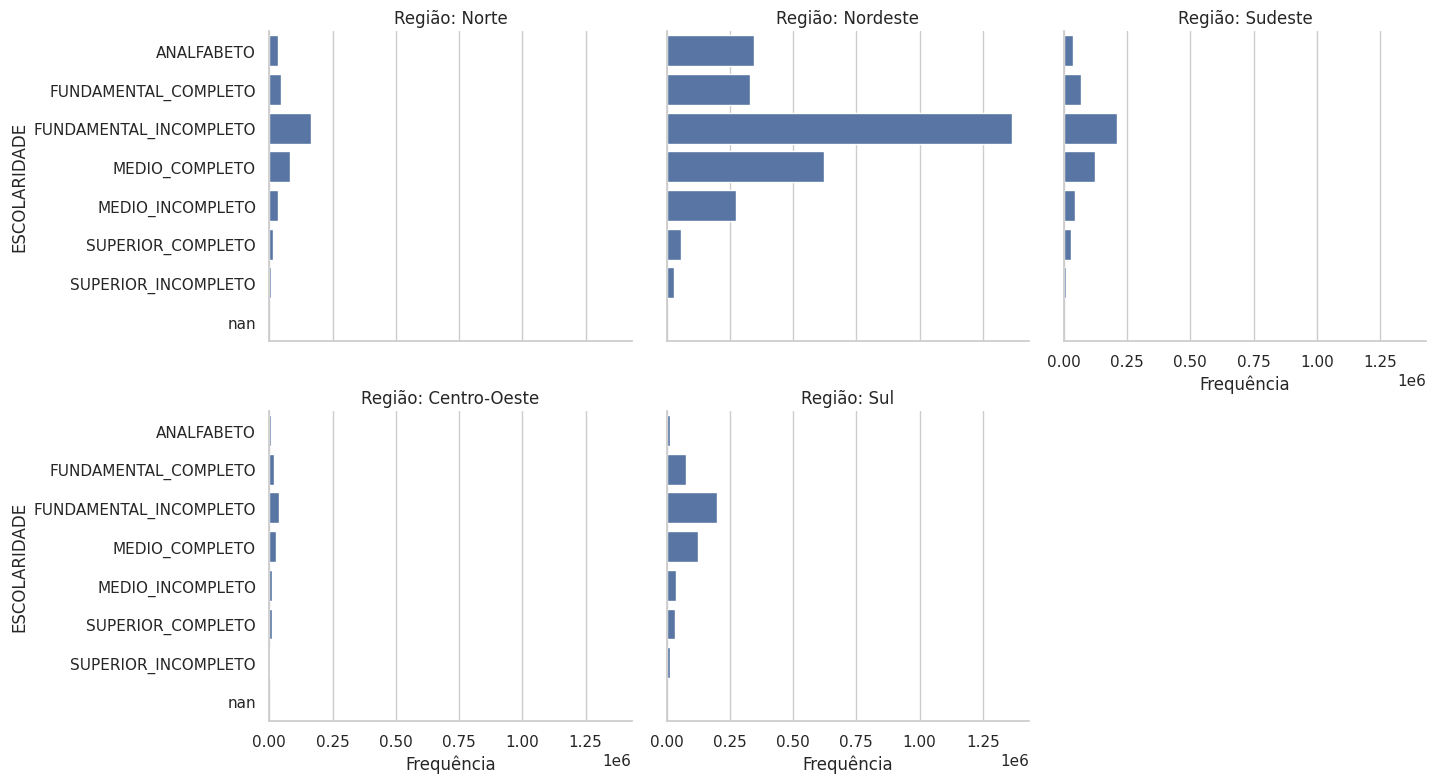

In [33]:
# Define o estilo
sns.set(style="whitegrid")

order_escolaridade = sorted(df_membros_area['ESCOLARIDADE'].astype(str).unique())

# Cria o gráfico de barras horizontais particionado por região
g = sns.catplot(
    data=df_membros_area,
    kind='count',
    y='ESCOLARIDADE',
    col='REGIAO',
    col_wrap=3,
    height=4,
    aspect=1.2,
    order=order_escolaridade)  # Para manter a ordem consistente


# Ajustes finais
g.set_titles("Região: {col_name}")
g.set_axis_labels("Frequência", "ESCOLARIDADE")
plt.tight_layout()
plt.show()

In [47]:
#Verificando a relação entre a ESCOLARIDADE e REGIAO

# Criando a tabela de contingência
tabela_contingencia = pd.crosstab(df_membros_area["ESCOLARIDADE"], df_membros_area["REGIAO"], margins=True, margins_name="Total")

# Teste de Qui-Quadrado
chi2, p, dof, expected = chi2_contingency(tabela_contingencia)

print(f"Chi2: {chi2}")
print(f"Valor-p: {p}")
print(f"Graus de liberdade: {dof}")


# Interpretando o valor-p
if p < 0.05:
    print("Existe uma relação significativa entre as variáveis.")
else:
   print("Não existe uma relação significativa entre as variáveis.")

# Coeficiente de Contingência
N = tabela_contingencia.sum().sum()  # Número total de observações
C = np.sqrt(chi2 / (chi2 + N))

print(f"Coeficiente de Contingência: {C:.3f}")

Chi2: 129389.31064297918
Valor-p: 0.0
Graus de liberdade: 35
Existe uma relação significativa entre as variáveis.
Coeficiente de Contingência: 0.084


#Como p < 0.05, você rejeita a hipótese nula de independência e conclui que HÁ RELAÇÃO SIGNIFICATIVA ENTRE AS VARIÁVEIS
#PORÉM, com o Coeficiente de Contingência tão baixo, indica quase nenhuma associação entre as varáveis.




In [38]:
# Função para calcular o V de Cramér
def cramers_v(chi2, n, x, y):
    return np.sqrt(chi2 / (n * min(x - 1, y - 1)))

# Calcular o V de Cramér
n = tabela_contingencia.sum().sum()  # Total de observações
x = tabela_contingencia.shape[0]  # Número de linhas (categorias da variável 1)
y = tabela_contingencia.shape[1]  # Número de colunas (categorias da variável 2)

v = cramers_v(chi2, n, x, y)
print(f"V de Cramér: {v}")

V de Cramér: 0.03776766054290575


# O **V de Cramér** = 0.03 ( entre 0.01 e 0.1), confirma que quase não há  ASSOCIAÇÃO entre as variáveis.

In [48]:
# CARREGANDO ARQUIVO DE RENDA
df_renda = pd.read_csv("/content/drive/My Drive/Colab Notebooks/MBA_Est_Desc_dados/RENDA.csv", sep=';', encoding='utf-8', dtype={
    "CAF":"string",
    "TIPO_RENDA":"string",
    "CATEGORIA_PRODUTO":"string",
    "PRODUTOL":"string",
    "VALOR_PRODUTO":"float"
}, decimal=",")

#Verificando a importação dos dados e variáveis
df_renda.info()

df_renda.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9177846 entries, 0 to 9177845
Data columns (total 5 columns):
 #   Column             Dtype  
---  ------             -----  
 0   CAF                string 
 1   TIPO_RENDA         string 
 2   CATEGORIA_PRODUTO  string 
 3   PRODUTO            object 
 4   VALOR_PRODUTO      float64
dtypes: float64(1), object(1), string(3)
memory usage: 350.1+ MB


,CAF,TIPO_RENDA,CATEGORIA_PRODUTO,PRODUTO,VALOR_PRODUTO
0,AC012023.01.000103697CAF,RENDAS FORA DO ESTABELECIMENTO,PREVIDENCIÁRIA RURAL,APOSENTADORIA RURAL,31512.0
1,AC012023.01.000103697CAF,PRODUÇÃO ANIMAL,PECUÁRIA DE CORTE,BOVINOS CORTE,72000.0
2,AC012023.01.000103709CAF,LAVOURAS TEMPORÁRIAS,FRUTICULTURA,ABACAXI,1400.0
3,AC012023.01.000103709CAF,SEMENTES E MUDAS,GRÃOS,SEMENTES - MILHO,6400.0
4,AC012023.01.000103709CAF,SILVICULTURA E EXTRATIVISMO,FRUTICULTURA,AÇAÍ,5000.0


In [49]:
# SOMANDO AS RENDAS DECLARADAS PARA IDENTIFICAR APENAS 1 POR TIPO.
df_renda_tipo = df_renda.groupby(['CAF', 'TIPO_RENDA'])['VALOR_PRODUTO'].sum().reset_index()
print(df_renda_tipo)

                              CAF                      TIPO_RENDA  \
0        AC012023.01.000103697CAF                 PRODUÇÃO ANIMAL   
1        AC012023.01.000103697CAF  RENDAS FORA DO ESTABELECIMENTO   
2        AC012023.01.000103709CAF            LAVOURAS TEMPORÁRIAS   
3        AC012023.01.000103709CAF                 PRODUÇÃO ANIMAL   
4        AC012023.01.000103709CAF  RENDAS FORA DO ESTABELECIMENTO   
...                           ...                             ...   
5526223  TO122024.01.002493568CAF  RENDAS FORA DO ESTABELECIMENTO   
5526224  TO122024.01.002494307CAF            LAVOURAS TEMPORÁRIAS   
5526225  TO122024.01.002494540CAF            LAVOURAS TEMPORÁRIAS   
5526226  TO122024.01.002494540CAF                 PRODUÇÃO ANIMAL   
5526227  TO122024.01.002494801CAF                           PESCA   

         VALOR_PRODUTO  
0             72000.00  
1             31512.00  
2             11400.00  
3            143400.00  
4             14400.00  
...                ..

In [ ]:
#TABELA DE FREQUENCIA DE TIPO DE RENDA
freq_tipo = df_renda_tipo.groupby('REGIAO')['CAF'].nunique().reset_index()
freq_uf.columns = ["Região", "Frequência"]
freq_uf

In [50]:
# JUNTANDO O DF DAS RENDAS AOS MEMBROS E AREA PRINCIPAL
df_membros_area_renda = pd.merge(df_membros_area, df_renda_tipo, on="CAF", how="inner")
df_membros_area_renda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11055425 entries, 0 to 11055424
Data columns (total 13 columns):
 #   Column                Dtype         
---  ------                -----         
 0   CAF                   string        
 1   CODIGO_PESSOA         string        
 2   SEXO                  category      
 3   DATA_NASCIMENTO       datetime64[ns]
 4   ESCOLARIDADE          category      
 5   MAO_DE_OBRA_FAMILIAR  category      
 6   IDADE                 int64         
 7   FAIXA_ETARIA          category      
 8   UF                    string        
 9   MUNICIPIO             string        
 10  REGIAO                object        
 11  TIPO_RENDA            string        
 12  VALOR_PRODUTO         float64       
dtypes: category(4), datetime64[ns](1), float64(1), int64(1), object(1), string(5)
memory usage: 801.3+ MB


In [51]:
df_membros_area_renda.head()

,CAF,CODIGO_PESSOA,SEXO,DATA_NASCIMENTO,ESCOLARIDADE,MAO_DE_OBRA_FAMILIAR,IDADE,FAIXA_ETARIA,UF,MUNICIPIO,REGIAO,TIPO_RENDA,VALOR_PRODUTO
0,AC012023.01.000103697CAF,228471,FEMININO,1950-02-17,ANALFABETO,SIM,75,70 a 79 anos,AC,PLÁCIDO DE CASTRO,Norte,PRODUÇÃO ANIMAL,72000.0
1,AC012023.01.000103697CAF,228471,FEMININO,1950-02-17,ANALFABETO,SIM,75,70 a 79 anos,AC,PLÁCIDO DE CASTRO,Norte,RENDAS FORA DO ESTABELECIMENTO,31512.0
2,AC012023.01.000103709CAF,228657,MASCULINO,1994-03-01,MEDIO_COMPLETO,SIM,31,30 a 39 anos,AC,FEIJÓ,Norte,LAVOURAS TEMPORÁRIAS,11400.0
3,AC012023.01.000103709CAF,228657,MASCULINO,1994-03-01,MEDIO_COMPLETO,SIM,31,30 a 39 anos,AC,FEIJÓ,Norte,PRODUÇÃO ANIMAL,143400.0
4,AC012023.01.000103709CAF,228657,MASCULINO,1994-03-01,MEDIO_COMPLETO,SIM,31,30 a 39 anos,AC,FEIJÓ,Norte,RENDAS FORA DO ESTABELECIMENTO,14400.0
